In [1]:
#https://github.com/pascal1129/kaggle_airbus_ship_detection/blob/master/1_detectron_infer/infer_airbus.py#

from collections import defaultdict
import argparse
import cv2  # NOQA (Must import before importing caffe2 due to bug in cv2)
import glob
import logging
import os
import sys
import time

import torch, torchvision

print(torch.__version__, torch.cuda.is_available())
#pip install -q -U "git+https://github.com/philferriere/cocoapi.git#egg=pycocotools&subdirectory=PythonAPI"


import pycocotools.mask as mask_util
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

from detectron2.config import get_cfg

import detectron2.utils.comm as comm
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

1.6.0 True


In [2]:
class Airbus_Submit(object):
    def __init__(self, thresh=0.4, csv_file_name='rle.csv'):
        
        self.thresh = thresh
        self.csv_file_name = csv_file_name

        self.csv_img  = []  # save img name
        self.csv_rle  = []  # save rle result
        self.csv_con  = []  # save confidence
        self.csv_area = []  # save the area of mask

    def extract_result(self, cls_boxes, cls_segms, cls_keyps, im_real_name, confidence):
        if isinstance(cls_boxes, list):
            boxes, segms, keypoints, classes = self.convert_from_cls_format(cls_boxes, cls_segms, cls_keyps)
        if (boxes is None or boxes.shape[0] == 0 or max(boxes[:, 4]) < self.thresh):
            return
        if segms is not None and len(segms) > 0:
            masks = np.array(decode(segms))
        if(masks is None):  # it means in the pic, confidence of all possible objects < thresh
            return
        self.mask_to_rle_csv(im_real_name, masks, confidence)
        
    def convert_from_cls_format(self, cls_boxes, cls_segms, cls_keyps):
        # Convert from the class boxes/segms/keyps format generated by the testing code.
        box_list = [b for b in cls_boxes if len(b) > 0]
        if len(box_list) > 0:
            boxes = np.concatenate(box_list)
        else:
            boxes = None
        if cls_segms is not None:
            segms = [s for slist in cls_segms for s in slist]
        else:
            segms = None
        if cls_keyps is not None:
            keyps = [k for klist in cls_keyps for k in klist]
        else:
            keyps = None
        classes = []
        for j in range(len(cls_boxes)):
            classes += [j] * len(cls_boxes[j])
        return boxes, segms, keyps, classes

    def rle_encode(self, img):
        pixels = img.T.flatten()    # T is needed here.
        pixels = np.concatenate([[0], pixels, [0]])
        runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
        runs[1::2] -= runs[::2]
        return ' '.join(str(x) for x in runs)

    def mask_to_rle_csv(self, img, masks,confidence):
        index = np.argsort(-confidence)                 # index sorted by confidence: high-->low
        bg = np.zeros((768,768), dtype=np.uint8)            # must let dtype=uint8.Otherwise xor will be wrong
        for i in index:
            mask = masks[:,:,i]
            if(mask is None or confidence[i]< self.thresh ):     # Sometimes mask maybe None, but can't use 'mask==None', if confidence[i]<0.5 it's impossible to use
                continue
            mask_xor = (mask^bg)&mask
            area = mask_xor.sum()                       # area of the mask
            if(area == 0):
                continue
            print(confidence[i])
            rle = self.rle_encode(mask_xor)
            bg += mask_xor

            self.csv_img.append(img)
            self.csv_rle.append(rle)
            self.csv_con.append(confidence[i])
            self.csv_area.append(area)
            
    def create_csv(self):
        df = pd.DataFrame({'ImageId':self.csv_img, 'EncodedPixels':self.csv_rle, 'confidence':self.csv_con, 'area':self.csv_area})
        df = df[['ImageId', 'EncodedPixels', 'confidence', 'area']]   # change the column index
        df.to_csv(self.csv_file_name, index=False, sep=str(','))
        print("%s is written successfully."%self.csv_file_name)

In [3]:
def create_test_datatset():    
    img_dir = 'input/test_v2/'
    dataset_dicts = []
    
    for img_path in glob.glob(img_dir + '*.jpg'):
        record = {}
        file_path = img_path
        image_id = img_path.split('/')[-1].split('.')[0]
        record['file_name'] = file_path
        record['image_id'] = image_id
        dataset_dicts.append(record)
    return dataset_dicts

test_dataset = create_test_datatset()
img_ids = []
pred_string = []

DatasetCatalog.register("submit_test1", create_test_datatset)
od_dataset = MetadataCatalog.get("submit_test1")

In [4]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("submit_test1", )
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
predictor = DefaultPredictor(cfg)

{'file_name': 'input/test_v2/00002bd58.jpg', 'image_id': '00002bd58'}


/opt/conda/lib/python3.7/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  filter_inds = filter_mask.nonzero()


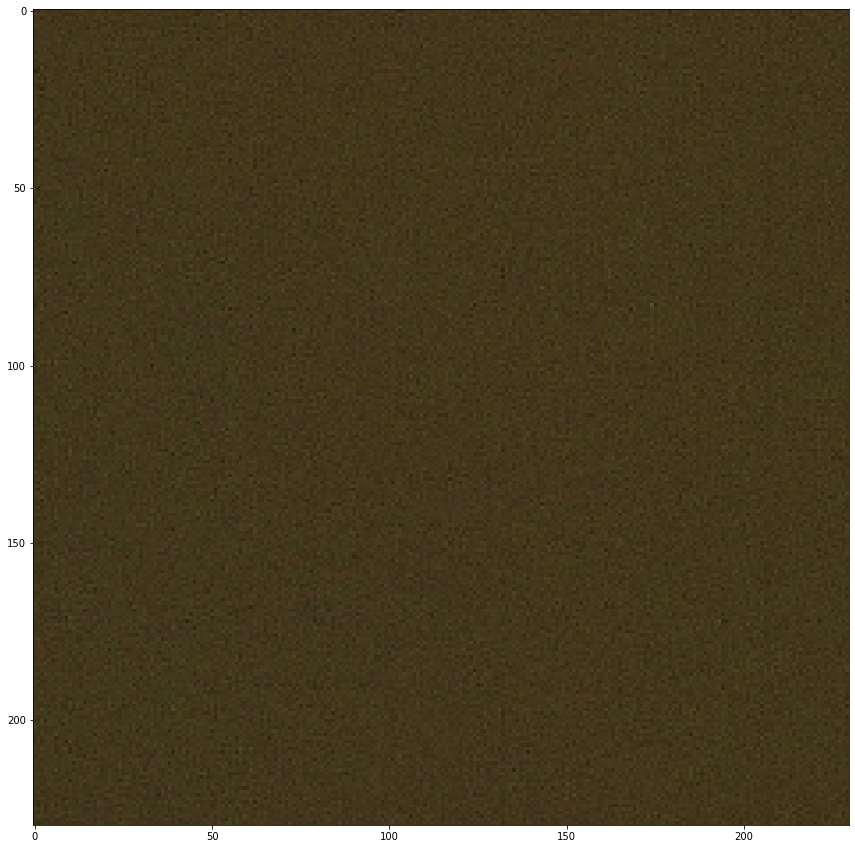

{'file_name': 'input/test_v2/00015efb6.jpg', 'image_id': '00015efb6'}


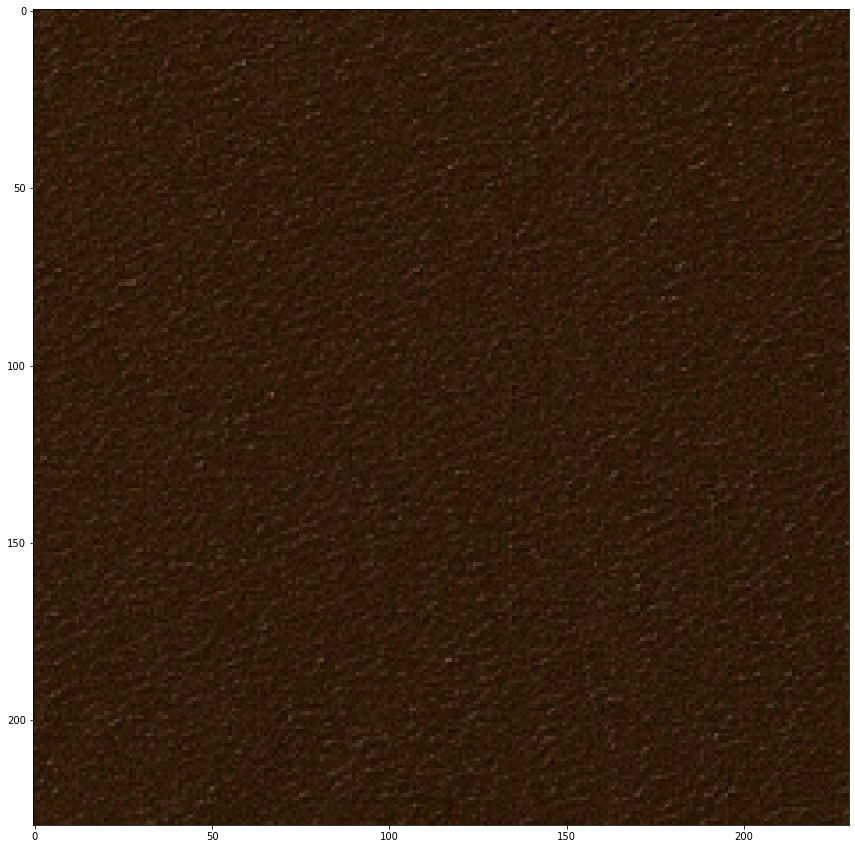

{'file_name': 'input/test_v2/00023d5fc.jpg', 'image_id': '00023d5fc'}


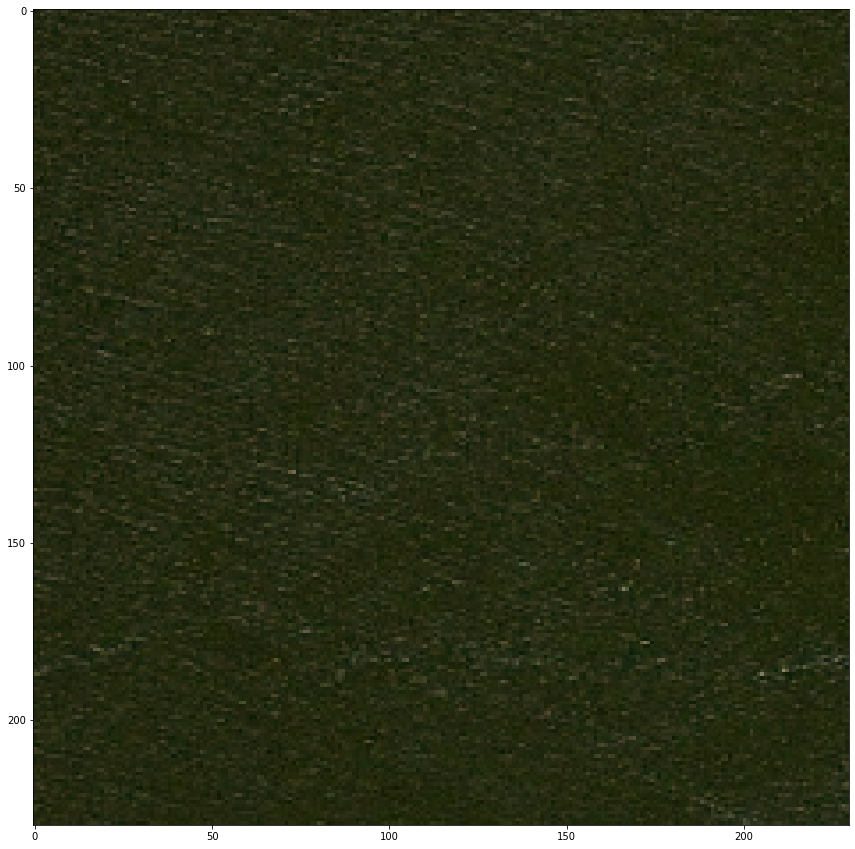

{'file_name': 'input/test_v2/000367c13.jpg', 'image_id': '000367c13'}


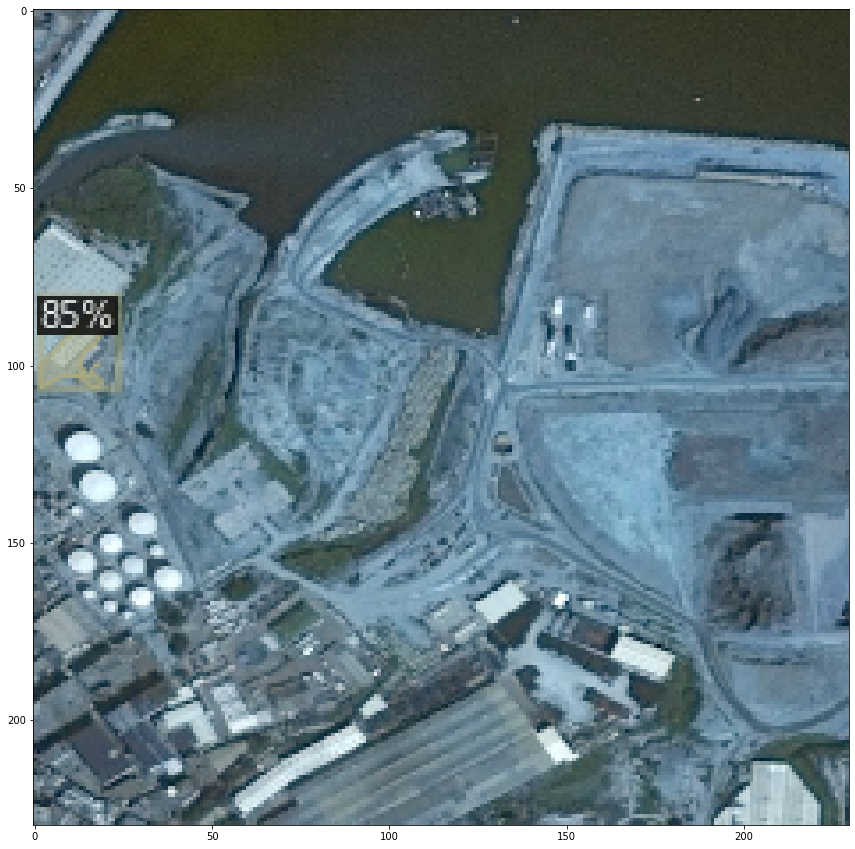

{'file_name': 'input/test_v2/0008ca6e9.jpg', 'image_id': '0008ca6e9'}


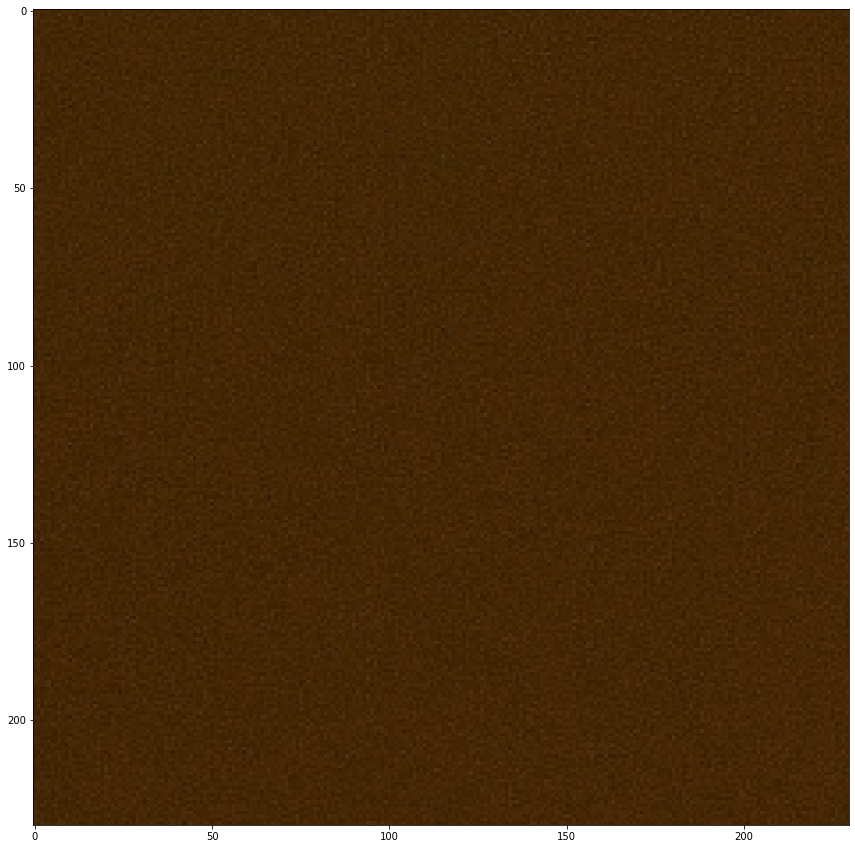

{'file_name': 'input/test_v2/000a4635f.jpg', 'image_id': '000a4635f'}


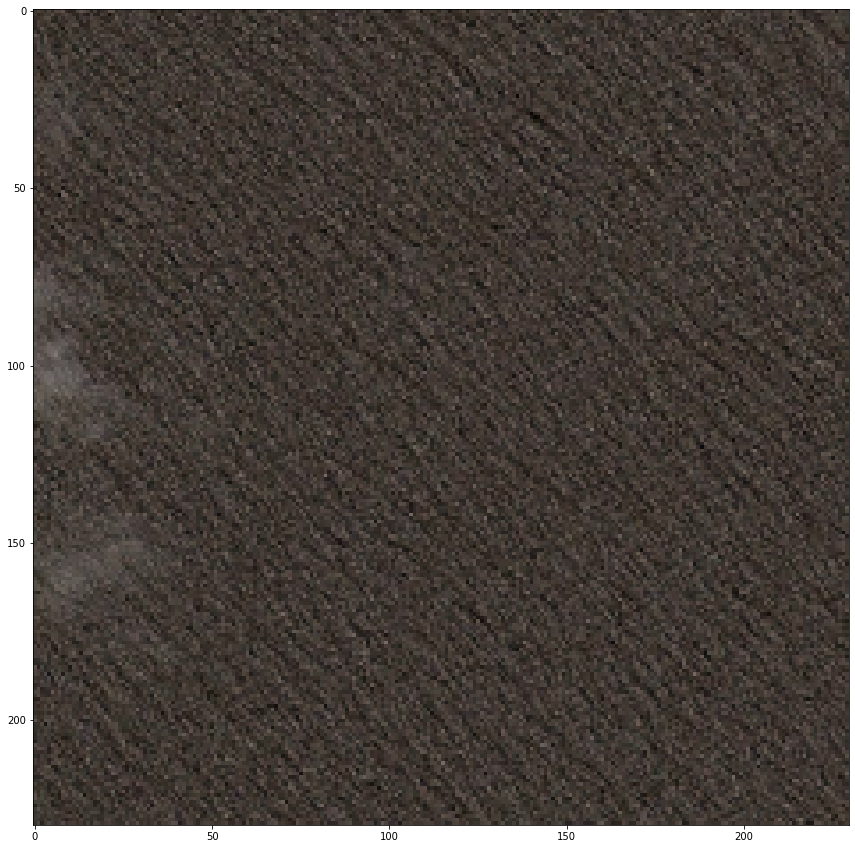

{'file_name': 'input/test_v2/000bd9dbf.jpg', 'image_id': '000bd9dbf'}


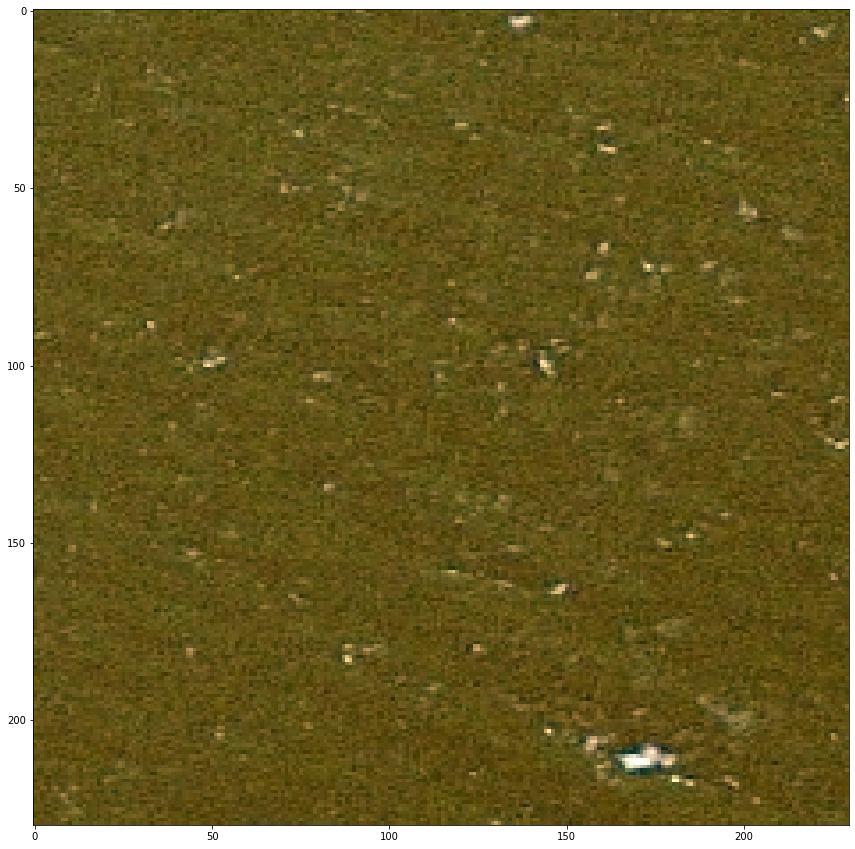

{'file_name': 'input/test_v2/000f7d875.jpg', 'image_id': '000f7d875'}


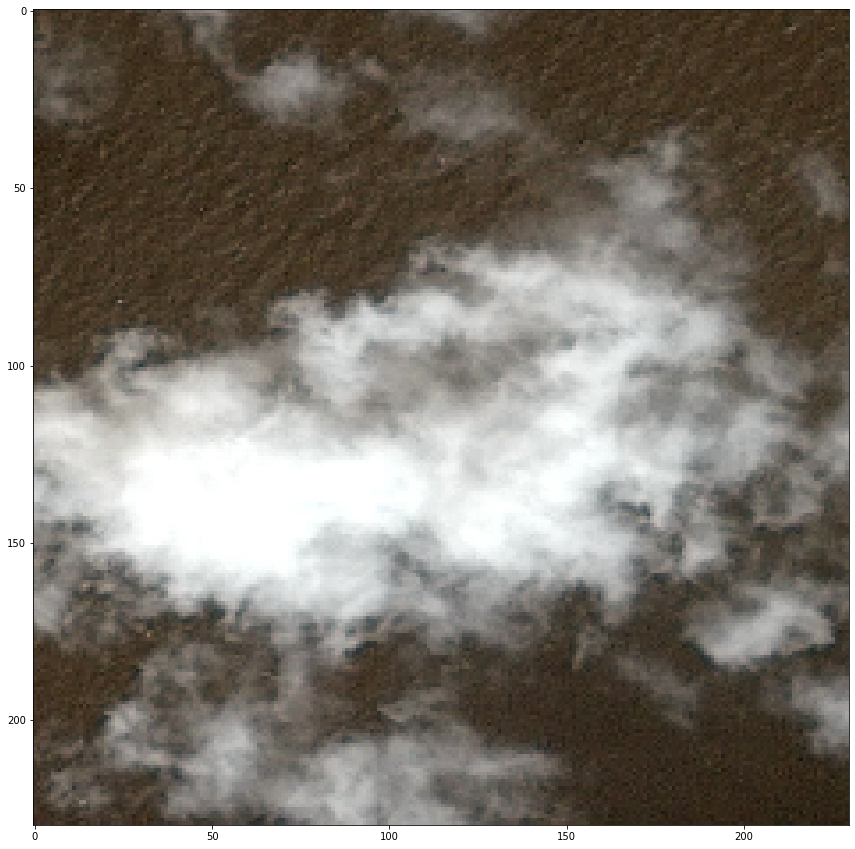

{'file_name': 'input/test_v2/0010551d9.jpg', 'image_id': '0010551d9'}


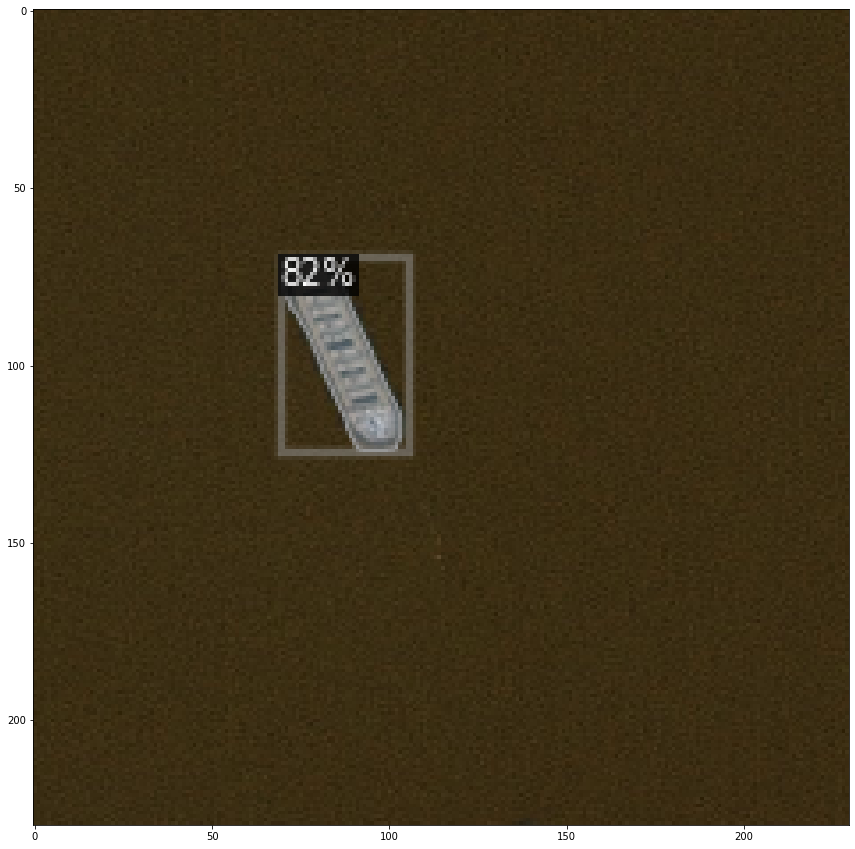

{'file_name': 'input/test_v2/001839c6f.jpg', 'image_id': '001839c6f'}


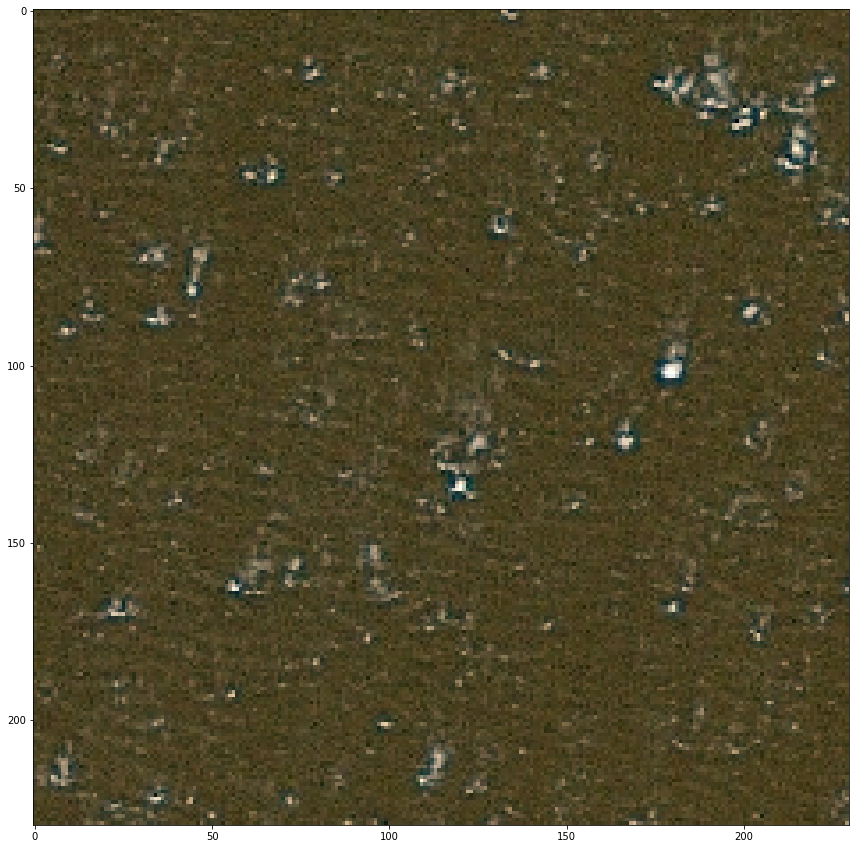

{'file_name': 'input/test_v2/002a943bf.jpg', 'image_id': '002a943bf'}


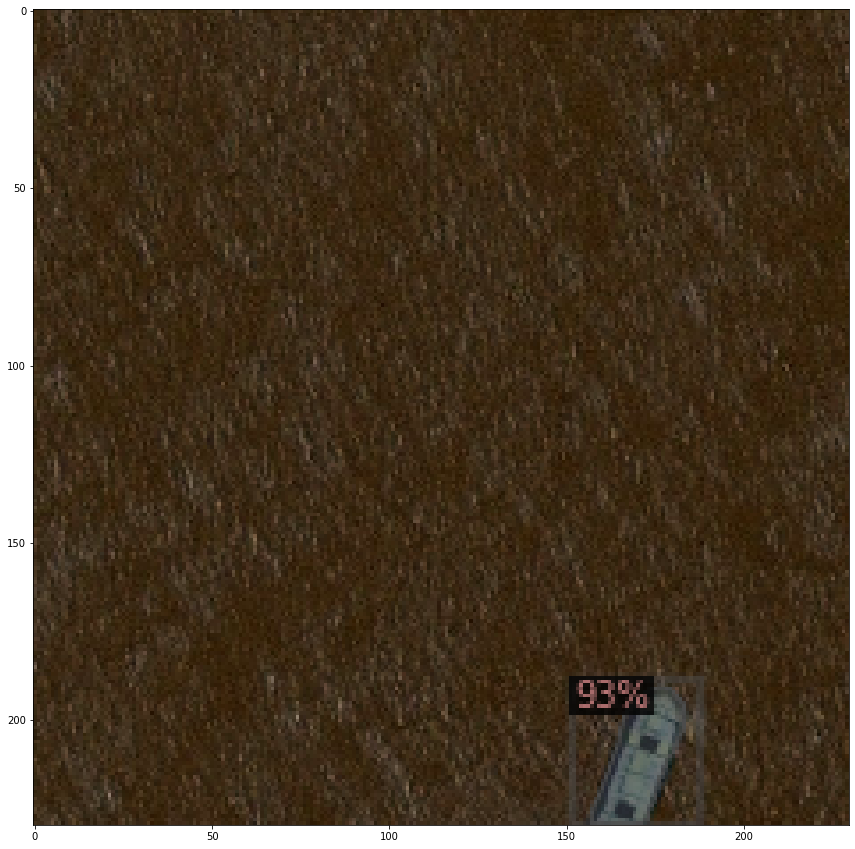

{'file_name': 'input/test_v2/00313b166.jpg', 'image_id': '00313b166'}


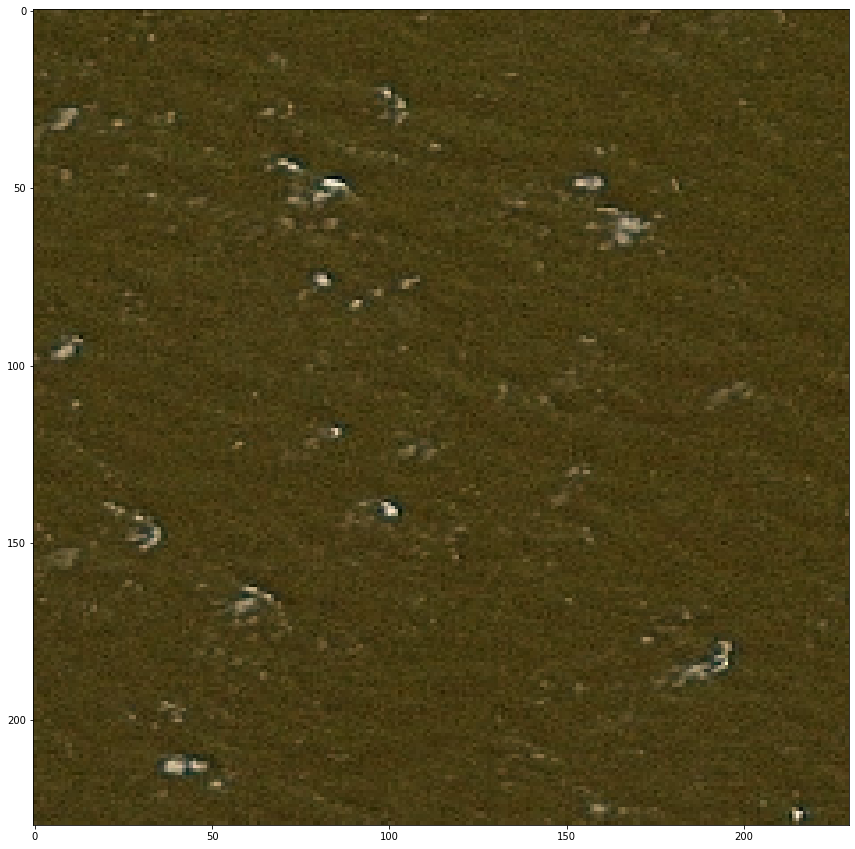

{'file_name': 'input/test_v2/00327b02d.jpg', 'image_id': '00327b02d'}


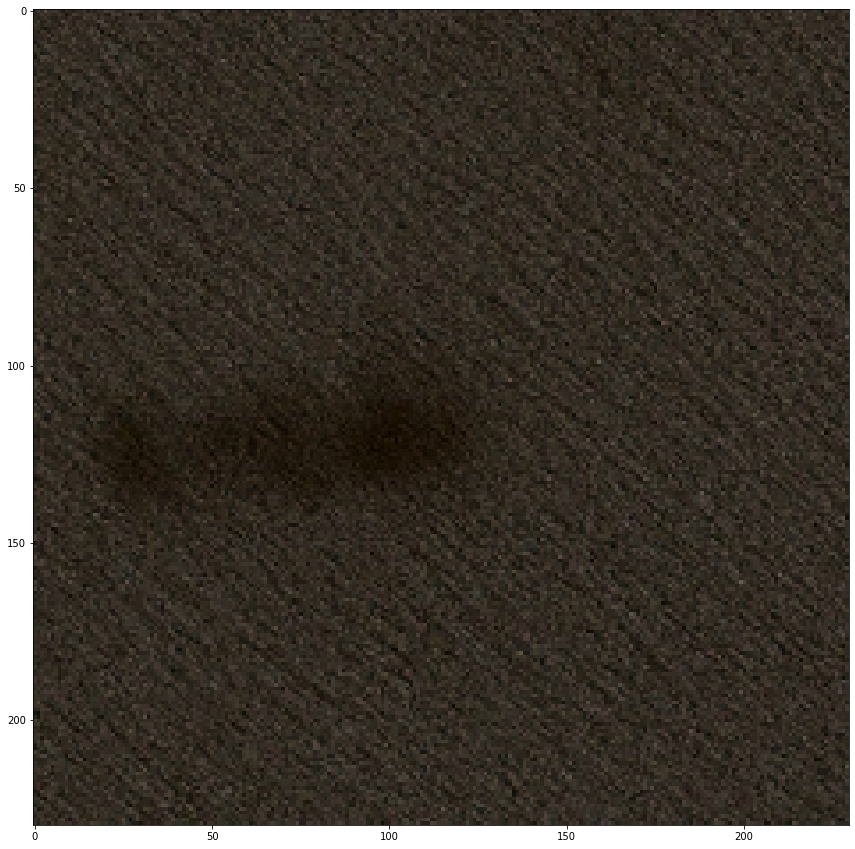

{'file_name': 'input/test_v2/0035268d9.jpg', 'image_id': '0035268d9'}


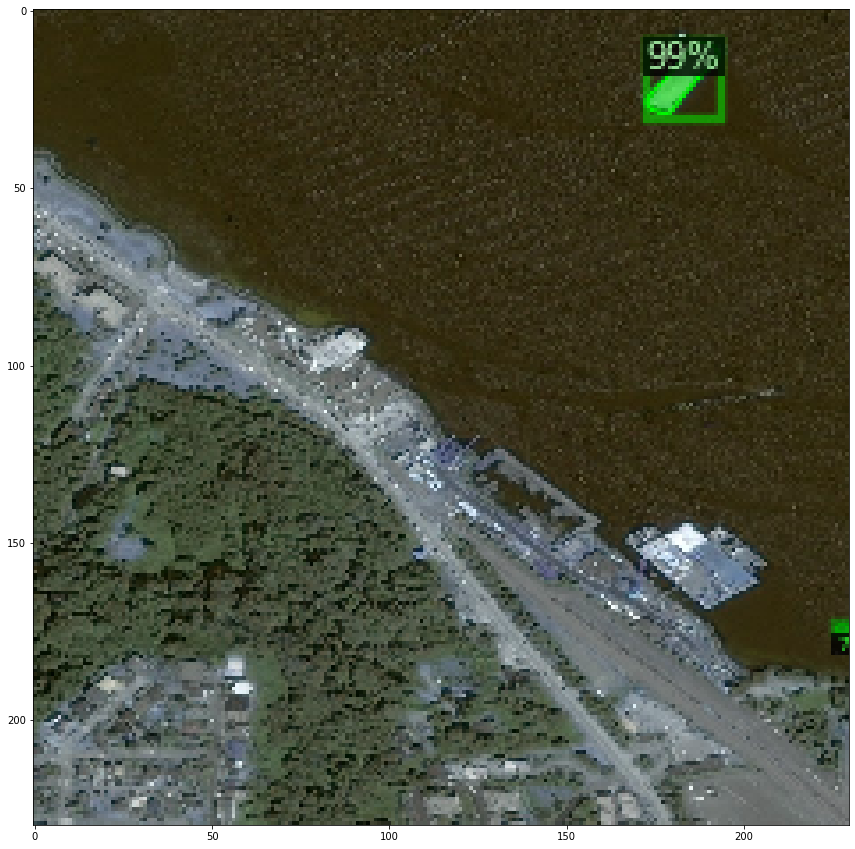

{'file_name': 'input/test_v2/003b58a76.jpg', 'image_id': '003b58a76'}


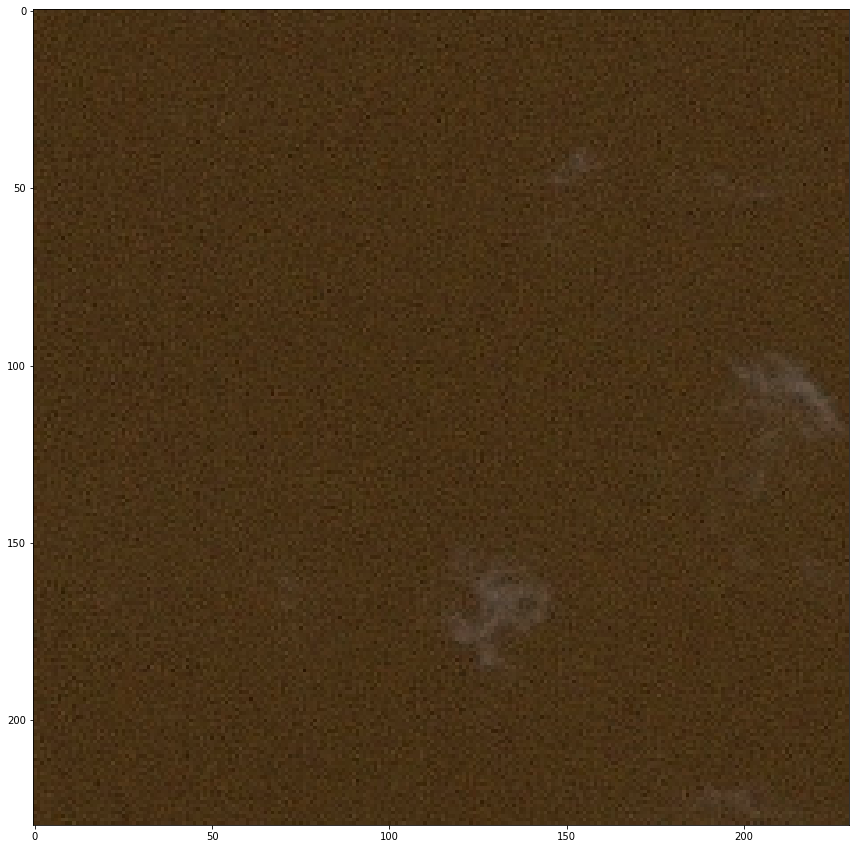

{'file_name': 'input/test_v2/0044e3dda.jpg', 'image_id': '0044e3dda'}


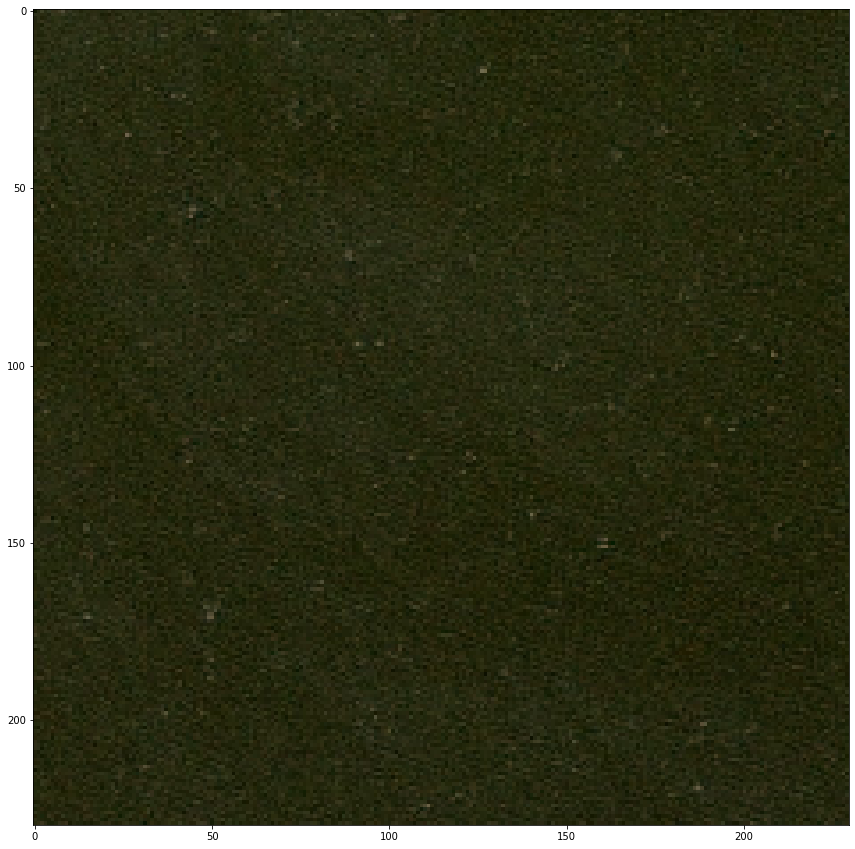

{'file_name': 'input/test_v2/0046967a4.jpg', 'image_id': '0046967a4'}


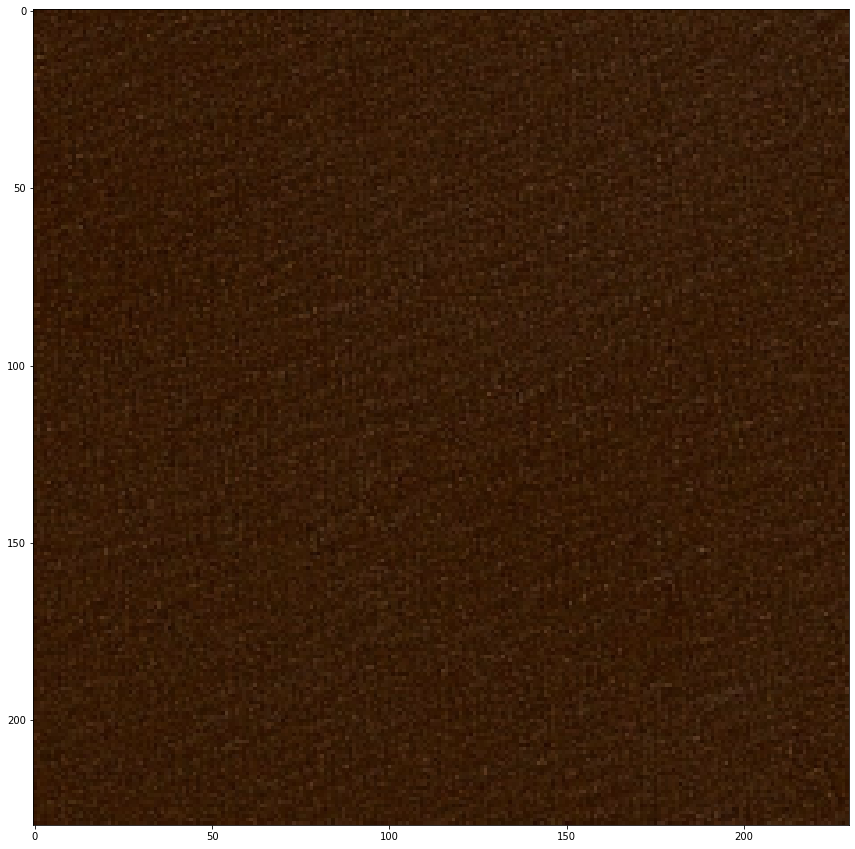

{'file_name': 'input/test_v2/004751507.jpg', 'image_id': '004751507'}


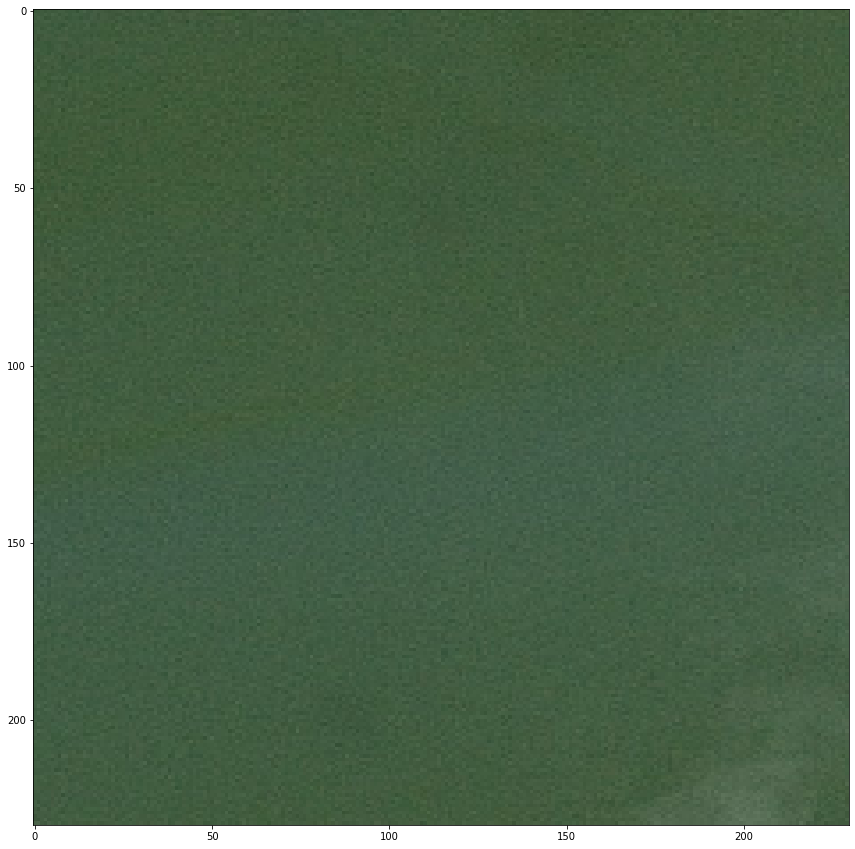

{'file_name': 'input/test_v2/0047c79fc.jpg', 'image_id': '0047c79fc'}


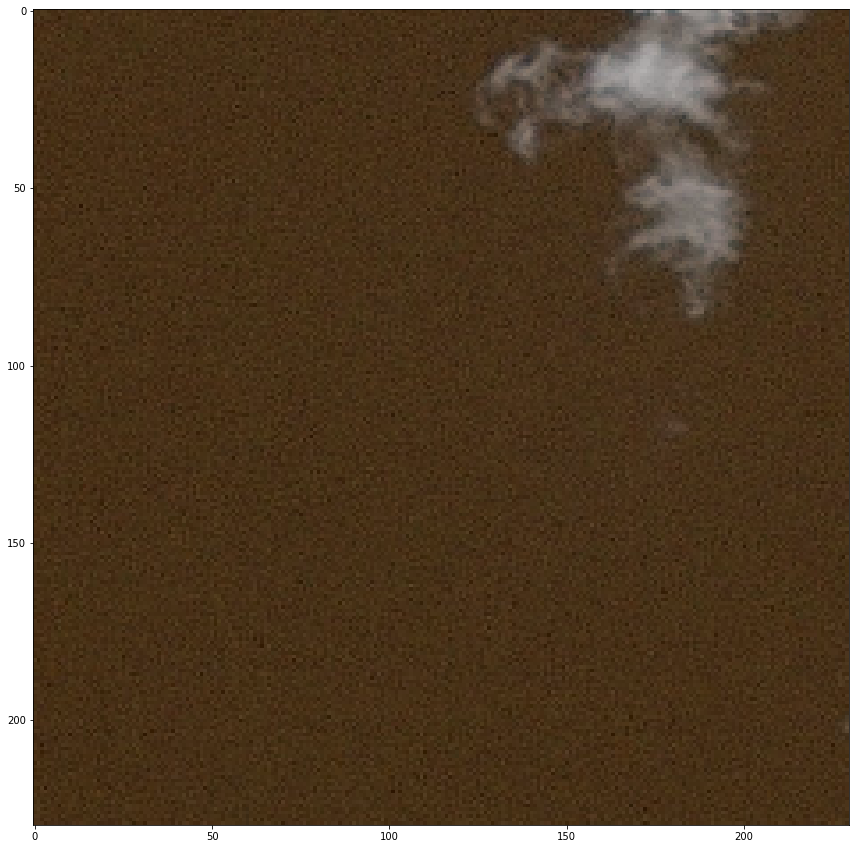

{'file_name': 'input/test_v2/004946ceb.jpg', 'image_id': '004946ceb'}


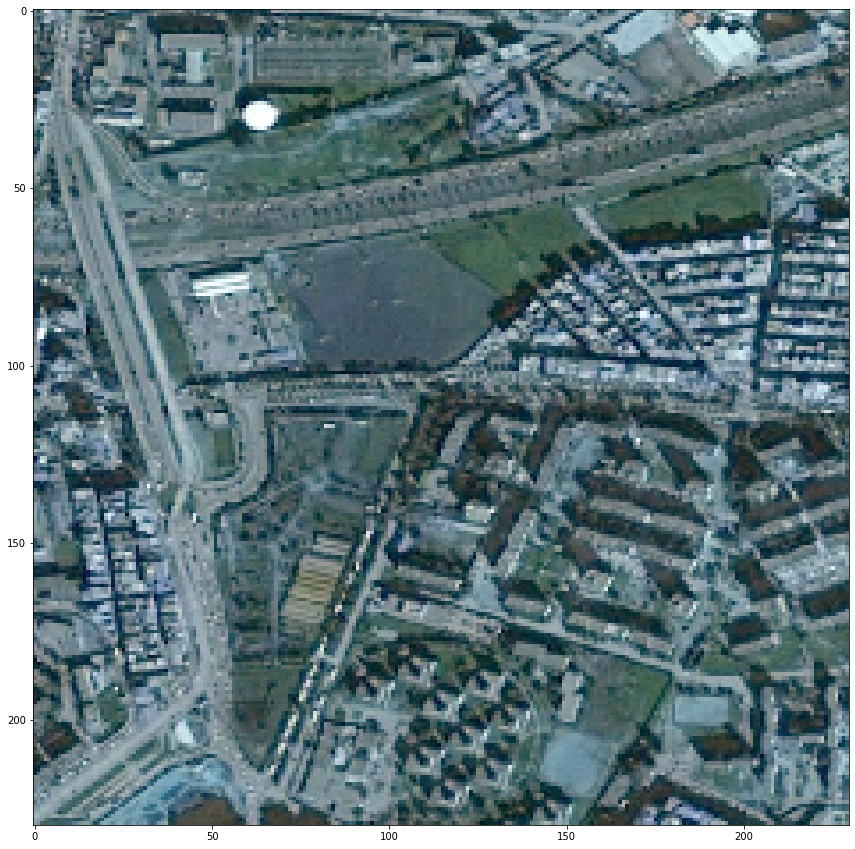

{'file_name': 'input/test_v2/004dd347a.jpg', 'image_id': '004dd347a'}


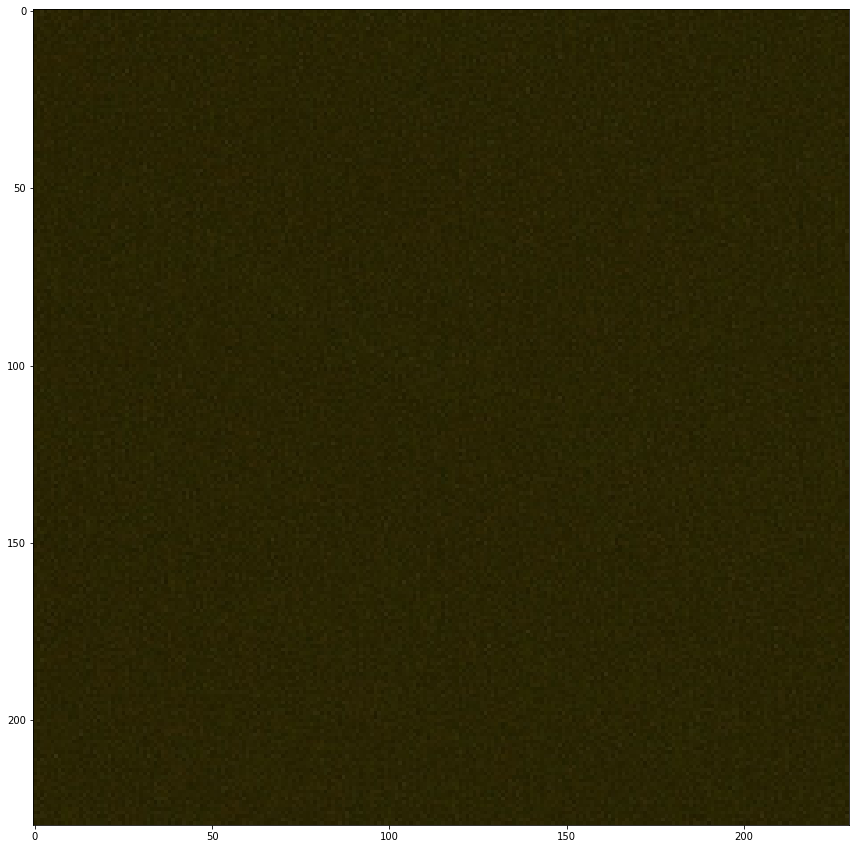

{'file_name': 'input/test_v2/00506a19e.jpg', 'image_id': '00506a19e'}


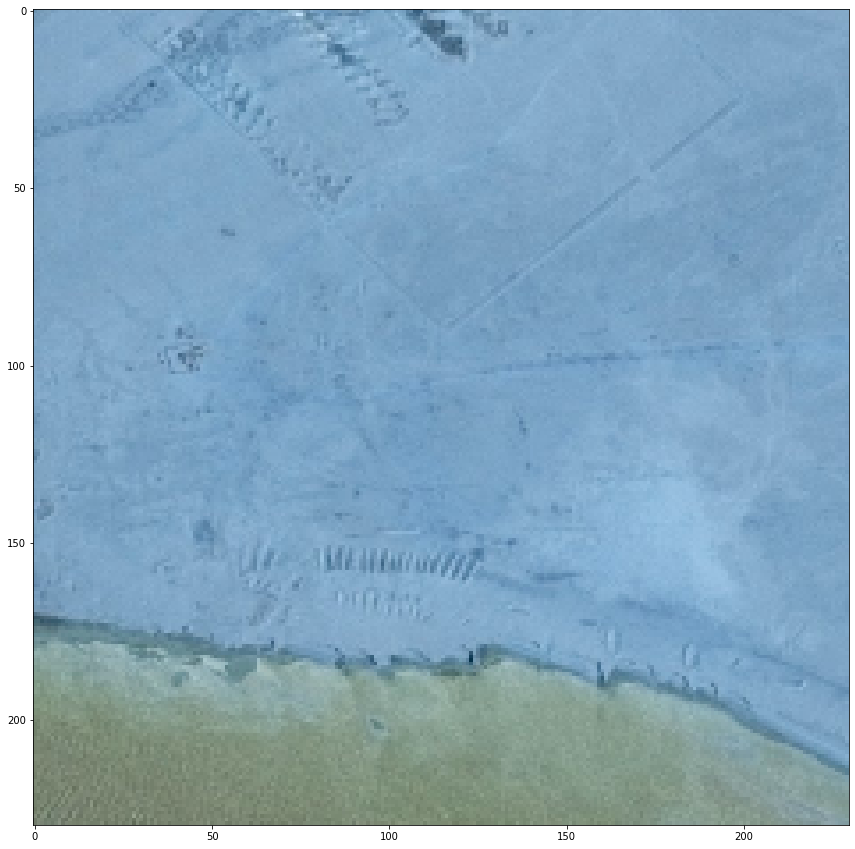

{'file_name': 'input/test_v2/0057c059b.jpg', 'image_id': '0057c059b'}


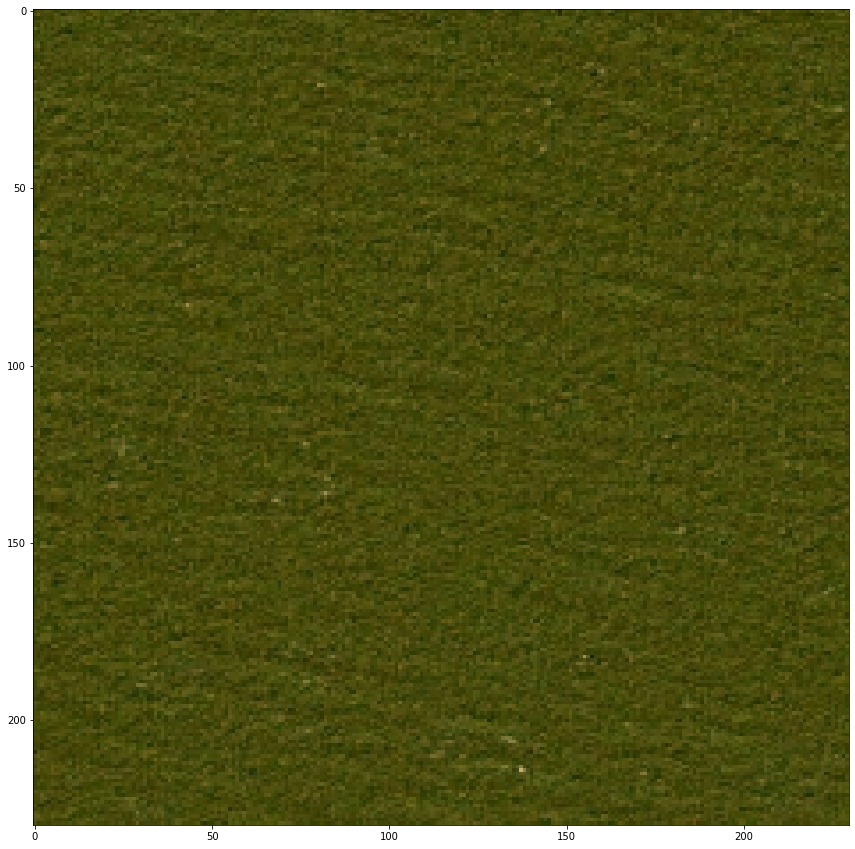

{'file_name': 'input/test_v2/005b8152d.jpg', 'image_id': '005b8152d'}


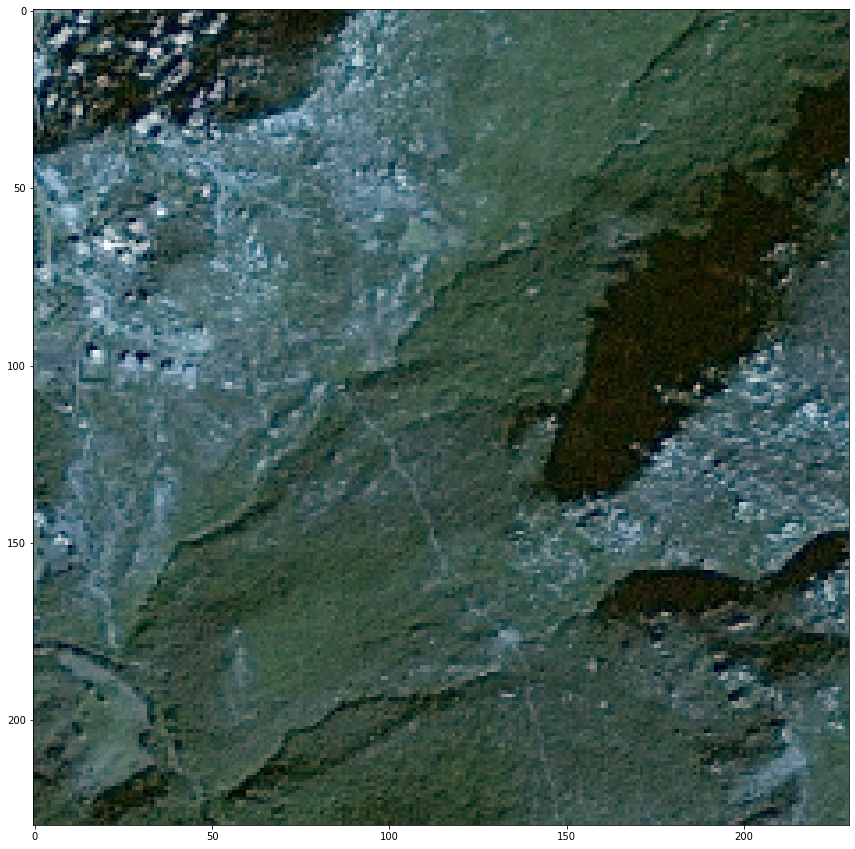

{'file_name': 'input/test_v2/0063cb1e9.jpg', 'image_id': '0063cb1e9'}


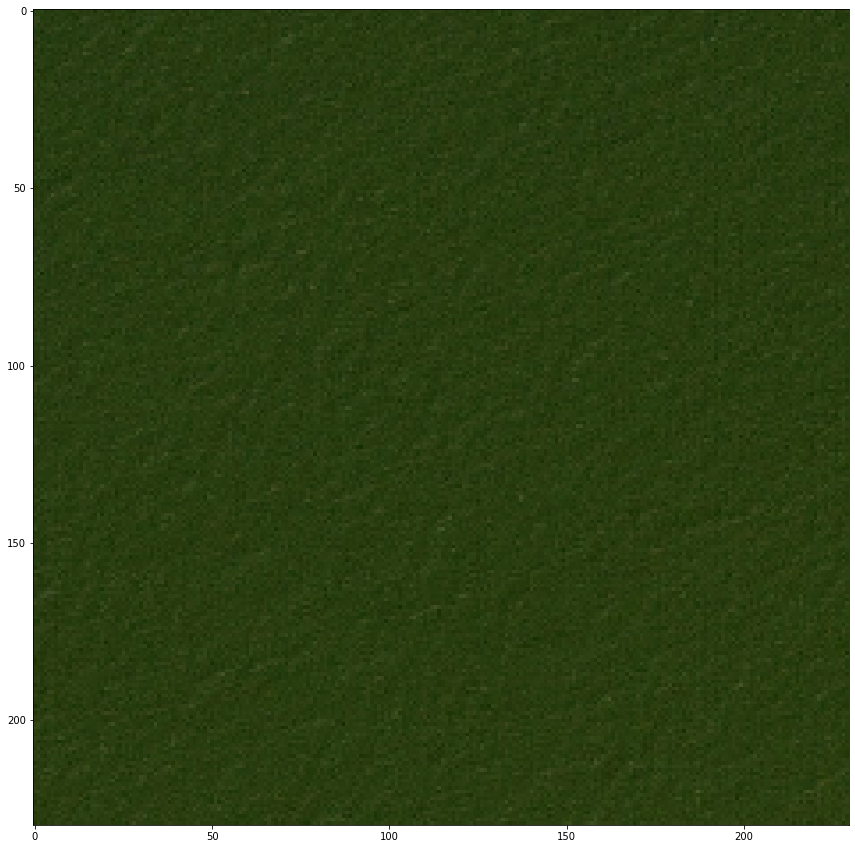

{'file_name': 'input/test_v2/00696ecc2.jpg', 'image_id': '00696ecc2'}


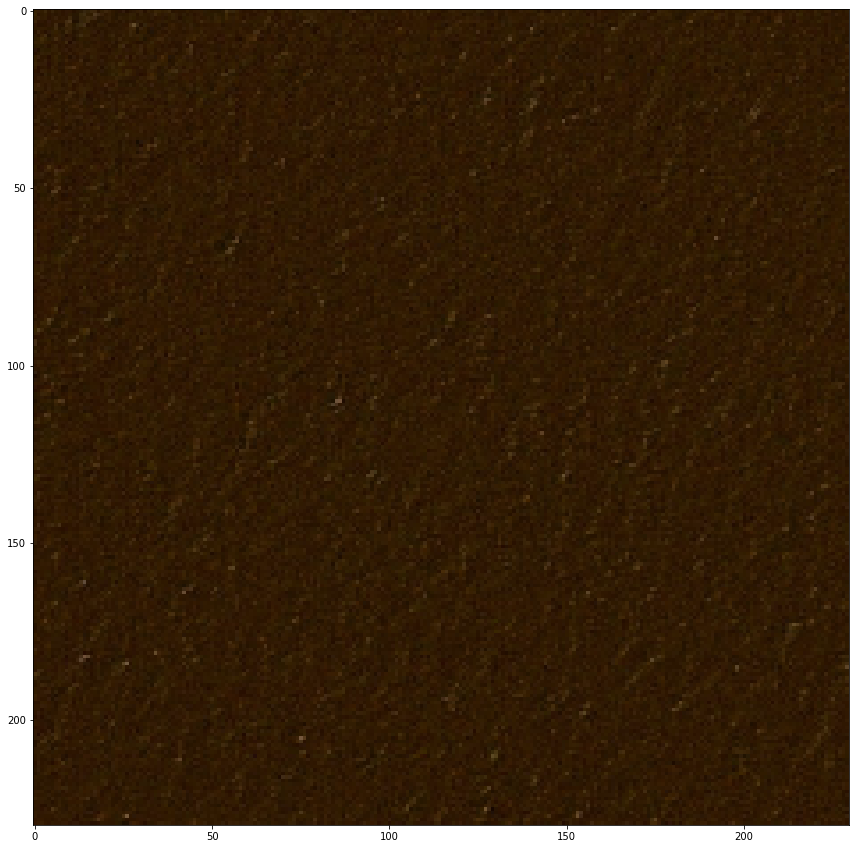

{'file_name': 'input/test_v2/006ba5b3b.jpg', 'image_id': '006ba5b3b'}


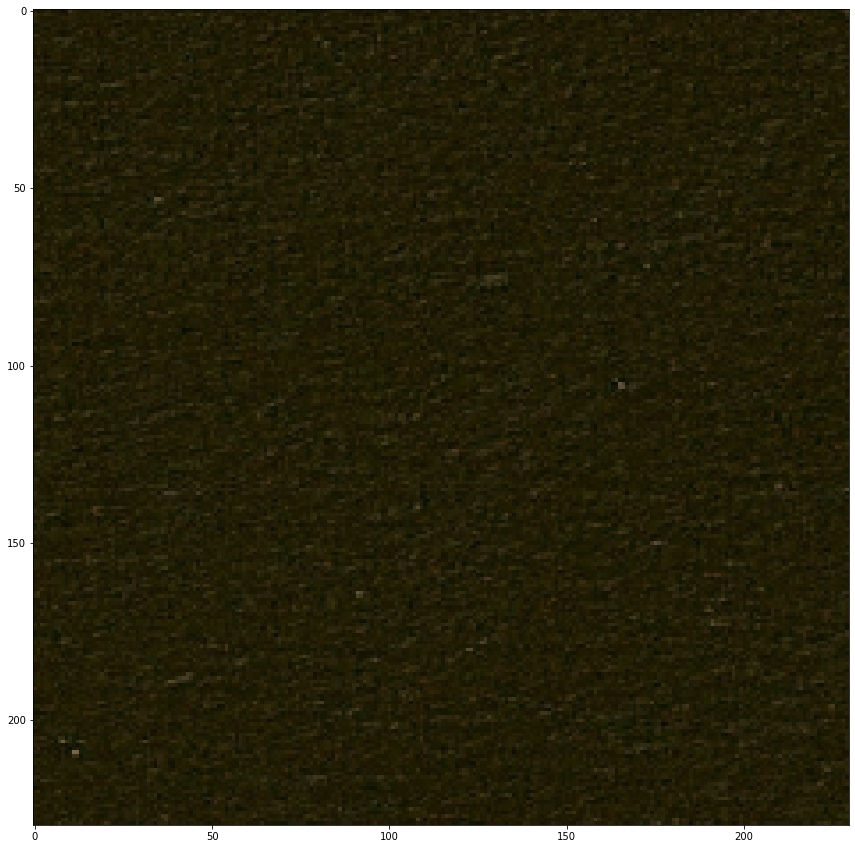

{'file_name': 'input/test_v2/007211988.jpg', 'image_id': '007211988'}


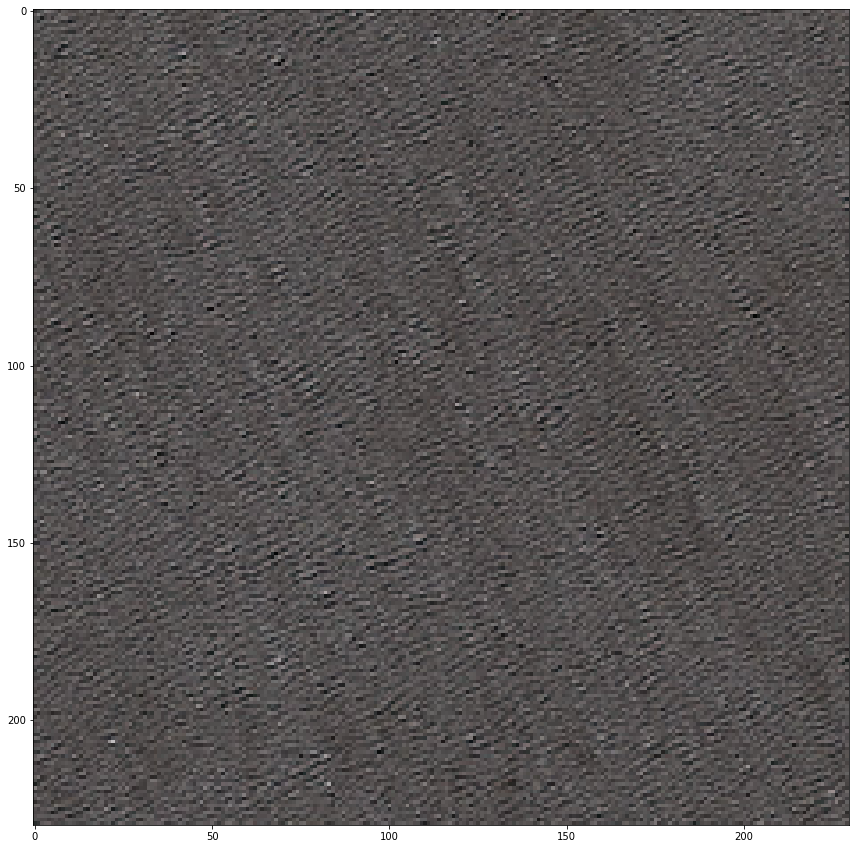

{'file_name': 'input/test_v2/007545acc.jpg', 'image_id': '007545acc'}


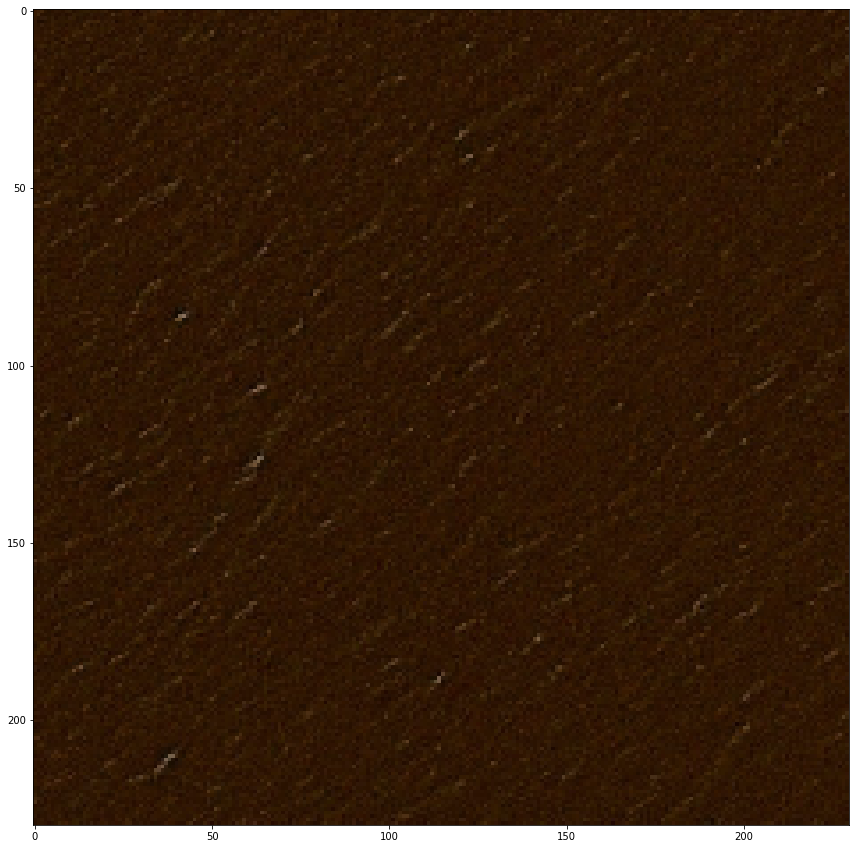

{'file_name': 'input/test_v2/0075cd3f1.jpg', 'image_id': '0075cd3f1'}


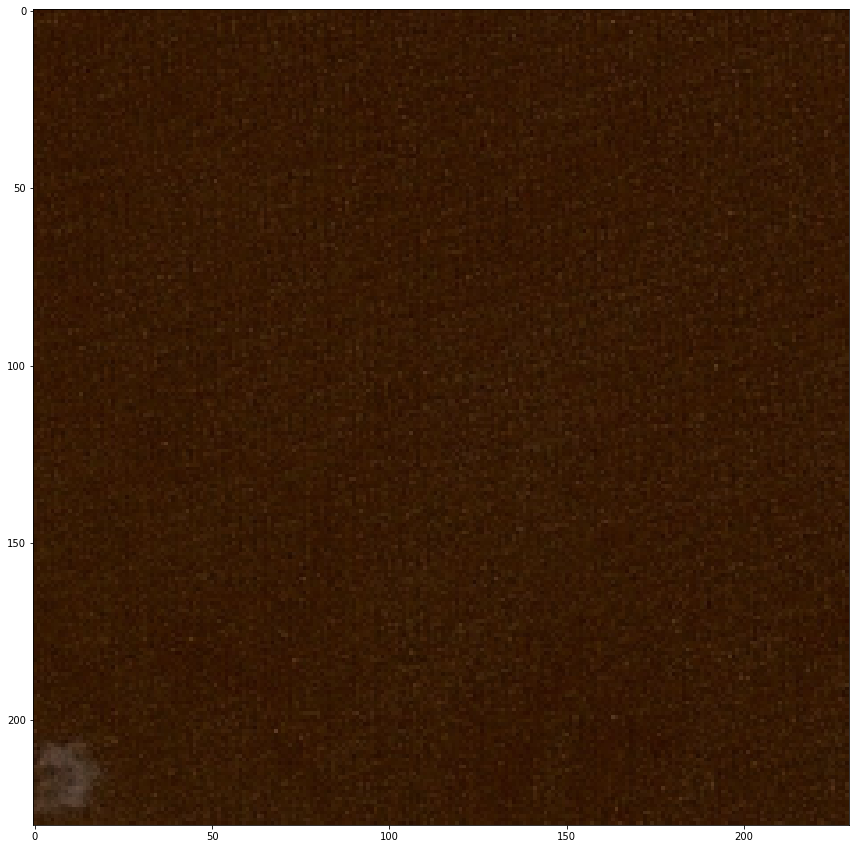

In [5]:
for test_data in test_dataset[0:30]:
    print(test_data)
    image_id = test_data['file_name'].split('/')[-1].split('.')[0]
    img = plt.imread(test_data['file_name'])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1], metadata=od_dataset, scale=0.3,)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu") )
    plt.figure(figsize=(25, 15))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

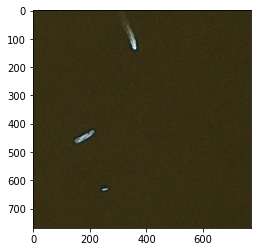

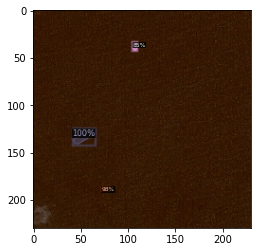

In [10]:
inputs = cv2.imread("input/test_v2/00a3ab3cc.jpg")
plt.imshow(inputs)
outputs = predictor(inputs)
v = Visualizer(img[:, :, ::-1], metadata=od_dataset, scale=0.3,)
v = v.draw_instance_predictions(outputs["instances"].to("cpu") )
plt.figure()
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

In [46]:
print(outputs["instances"])

Instances(num_instances=3, image_height=768, image_width=768, fields=[pred_boxes: Boxes(tensor([[138.3838, 419.0229, 219.9001, 479.0630],
        [242.1159, 624.9703, 266.5496, 638.7938],
        [351.1163, 116.1972, 365.0187, 143.1329]], device='cuda:0')), scores: tensor([0.9982, 0.9835, 0.8481], device='cuda:0'), pred_classes: tensor([0, 0, 0], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
 

[[138.38376 419.02292 219.90015 479.063  ]
 [242.11588 624.97034 266.5496  638.7938 ]
 [351.11627 116.19718 365.01874 143.1329 ]]


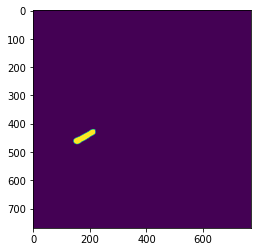

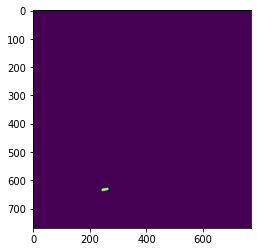

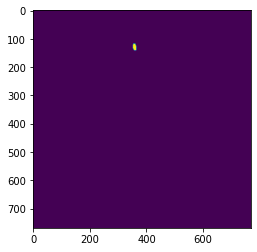

In [52]:
bboxes = outputs["instances"].pred_boxes.tensor
print(bboxes.cpu().numpy())

plt.figure()
plt.imshow(outputs["instances"].pred_masks.cpu().numpy()[0])
plt.figure()
plt.imshow(outputs["instances"].pred_masks.cpu().numpy()[1])
plt.figure()
plt.imshow(outputs["instances"].pred_masks.cpu().numpy()[2])

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
3


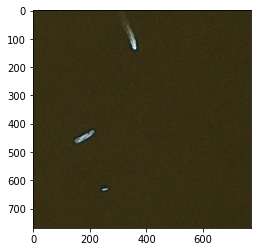

In [81]:
inputs = cv2.imread("input/test_v2/00a3ab3cc.jpg")
plt.imshow(inputs)
outputs = predictor(inputs)
masks = outputs["instances"].pred_masks.cpu().numpy()
print(masks[0])
print(masks.shape[0])

In [153]:

def rle_encode(img):
    pixels = img.T.flatten()    # T is needed here.
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def mask_to_rle_csv(masks):
    
    bg = np.zeros((768,768), dtype=np.uint8)   
    
    rle_list = []
    bg_list = []
    
    for i in range(masks.shape[0]):
        mask = masks[i,:,:]
        if(mask is None):
            continue
        mask_xor = (mask^bg)&mask
        area = mask_xor.sum()
        if(area == 0):
            continue
        rle = rle_encode(mask_xor)
        rle_list.append(rle)
        
        #bg += mask_xor
        #bg_list.append(bg)
        
    return ' '.join(rle_list)
    
def img_pred_rle(file_name):
    inputs = cv2.imread(file_name)
    #plt.figure()
    #plt.title(file_name)
    #plt.imshow(inputs)
    outputs = predictor(inputs)
    masks = outputs["instances"].pred_masks.cpu().numpy()
    return mask_to_rle_csv(masks)

# Ships have to be seperate - no overlaps -.-
def split_mask(mask):
    threshold = 0.5
    threshold_obj = 30 #ignor predictions composed of "threshold_obj" pixels or less
    labled,n_objs = ndimage.label(mask > threshold)
    result = []
    for i in range(n_objs):
        obj = (labled == i + 1).astype(int)
        if(obj.sum() > threshold_obj): result.append(obj)
    return result







img_ids = []
pred_strings = []

for i in range(len(test_dataset)): #For some reason it doesn't let for img in test_dataset -.-... appending error.
    img_ids.append(test_dataset[i]['file_name'].split('/')[-1])
    pred_strings.append(img_pred_rle(test_dataset[i]['file_name']))
    if(i%1000 == 0):
        print(i,len(test_dataset))

0 15606
1000 15606
2000 15606
3000 15606
4000 15606
5000 15606
6000 15606
7000 15606
8000 15606
9000 15606
10000 15606
11000 15606
12000 15606
13000 15606
14000 15606
15000 15606


In [154]:
print(len(test_dataset))

df = pd.DataFrame({'ImageId':img_ids, 'EncodedPixels':pred_strings})
print(df)
df.to_csv(csv_file_name, index=False, sep=str(','))

15606
             ImageId EncodedPixels
0      00002bd58.jpg              
1      00015efb6.jpg              
2      00023d5fc.jpg              
3      000367c13.jpg              
4      0008ca6e9.jpg              
...              ...           ...
15601  ffdb3cda6.jpg              
15602  ffe3857eb.jpg              
15603  ffeb765e8.jpg              
15604  ffeba1475.jpg              
15605  fff0fd44f.jpg              

[15606 rows x 2 columns]


In [126]:

test_dataset[0]['file_name'].split('/')[-1]

csv_file_name = "submission.csv"

print(test_dataset[0]['file_name'])



{'file_name': 'input/test_v2/000367c13.jpg', 'image_id': '000367c13'}
input/test_v2/00002bd58.jpg
